In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Data Preprocessing
#This section of code uses the code from https://github.com/AyanPahari/SVM-on-GISETTE-Dataset

fil= open("gisette_train.data") #opening the file
X_train=[]
for row in fil.readlines(): #reading the file line by line
    X_train.append((row.strip()).split()) #to get the values tuple by tuple without any whitespaces
fil.close()
#after this train will contain all the data in form of a numpy array

#repeating the same thing for test and valid samples as well

fil= open("gisette_train.labels")
y_train=[]
for row in fil.readlines():
    y_train.append((row.strip()).split())
fil.close()

fil= open("gisette_valid.data")
X_test=[]
for row in fil.readlines():
    X_test.append((row.strip()).split())
fil.close()

fil= open("gisette_valid.labels")
y_test=[]
for row in fil.readlines():
    y_test.append((row.strip()).split())
fil.close()

#some type conversions
X_train=np.array(X_train).astype(int)
y_train= np.array(y_train).astype(int)[:,0]

#some type conversions
X_test=np.array(X_test).astype(int)
y_test= np.array(y_test).astype(int)[:,0]

In [3]:
#converting from numpy array to pandas dataframe
X = pd.DataFrame(X_train)
y = y_train
val_train = pd.DataFrame(X_test)
val_test = y_test

In [4]:
import sklearn
from sklearn import preprocessing

In [5]:
#Data Scaling to [-1,1] for Logistic Regression

X_np = np.array(X)
minmaxscaler = preprocessing.MinMaxScaler(feature_range = (-1,1))
minmaxscaler.fit(X_np)
X_np_scaled = minmaxscaler.transform(X_np)

In [6]:
#Random Permutation
perm = np.random.permutation(X_np_scaled.shape[0])
new_range = perm[:2000]

#Picking only 2000 samples to match results from paper
X_new_np_scaled = X_np_scaled[new_range]
y_new = y[new_range]

In [7]:
#Activation function and Prediction Accuracy Fn

def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

def prediction_accuracy(X,y,w):
    z = np.matmul(X,w)
    preds = sigmoid(z)
    y_hat = np.zeros(y.shape[0])
    for i in range(len(preds)):
        if preds[i]>0.5:
            y_hat[i] = 1
        else:
            y_hat[i] = -1
    y_hat = np.array(y_hat)
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count+=1
    acc = count/y.shape[0]
    return acc

In [8]:
#Cost Function

def LogisticCost(X,y,w):
    z = -np.matmul(X,w)*y
    m = X.shape[0]
    cost = (1/m)*np.sum(np.log(1+np.exp(z)))
    return cost   

In [9]:
#Boosted FW functions

def gradient(X,y,w):
    z = -np.matmul(X,w)*y
    dz = np.exp(z)/(1+np.exp(z))
    dw = -(1/X.shape[0])*np.matmul(X.T,dz*y)
    return dw
        

def LassoMin(g,T): #LMO
    abs_g = np.abs(g)
    idx = np.argmax(abs_g)
    std_basis_vector = np.zeros(g.shape[0])
    std_basis_vector[idx] = 1
    return -T*np.sign(g[idx])*std_basis_vector    

def LassoMax(g,T): #FW step for boosted FW
    abs_g = np.abs(g)
    idx = np.argmax(abs_g)
    std_basis_vector = np.zeros(g.shape[0])
    std_basis_vector[idx] = 1
    return T*np.sign(g[idx])*std_basis_vector 

def proj_IP(r_k,v_k,x_k,d_k): #Projected vector aligned with v_k
    if np.linalg.norm(d_k) != 0:
        if np.dot(r_k,v_k-x_k)>np.dot(r_k,-d_k/(np.linalg.norm(d_k))):
            return v_k-x_k
        else:
            return -d_k/(np.linalg.norm(d_k))
    else:
        return v_k-x_k

def align(d,d_hat): #alignment measurement
    if np.linalg.norm(d_hat) == 0:
        return -1
    else:
        return np.dot(d,d_hat)/(np.linalg.norm(d)*np.linalg.norm(d_hat))

In [10]:
#Boosted FW Algorithm

def FW_boostedLogisticRegression(w,X,y,K,delta,tau,T,L):
    w_0 = LassoMin(gradient(X,y,w),tau)
    function_values = []
    itr = []
    Kt = K
    endFlag = False
    i=0
    while (i <= T) or (endFlag!=True):
        d_0 = np.zeros(w_0.shape)
        lambda_t = 0
        for j in range(Kt):
            r_k = -gradient(X,y,w_0)-d_0
            v_k = LassoMax(r_k,tau)
            u_k = proj_IP(r_k,v_k,w_0,d_0)
            lambda_k = np.dot(r_k,u_k)/(np.linalg.norm(u_k)**2)
            d_temp = d_0
            d_0 = d_0 + lambda_k*u_k
            if abs(align(-gradient(X,y,w_0),d_temp)-align(-gradient(X,y,w_0),d_0))>=delta:
                if np.array_equal(u_k,v_k-w_0):
                    lambda_t = lambda_t + lambda_k
                else:
                    lambda_t = lambda_t*(1-lambda_k/(np.linalg.norm(d_01)))
            else:
                Kt = j
                break 
        g_t = d_0/lambda_t
        eta_t = align(-gradient(X,y,w_0),g_t)
        gamma_t = max(0,min(eta_t*np.linalg.norm(gradient(X,y,w_0))/(L*np.linalg.norm(g_t)),1))
        w_0 = w_0 + gamma_t*g_t
        itr.append(i)
        i +=1 
        function_values.append(LogisticCost(X,y,w_0))  
        if i%100 == 0:
            print("Current State",LogisticCost(X,y,w_0),gamma_t,endFlag)
        if abs(np.dot(gradient(X,y,w_0),(w_0-v_k)))<delta:
            endFlag = True
            break
    return function_values,itr,w_0

In [11]:
#Boosted FW Initialization 

tau = 10 #Paper l1 norm constraint
L = 0.5 #Lipschitz (from paper)
delta = 0.0001 #tol (from paper)
K = 100000 #ideally inf but high value
T = 500 #No of time Steps
w = np.zeros(X.shape[1])
l = np.random.permutation(X.shape[1])
w[l[0:10]]=1 #randomly assign 1 to 10 weight elements
print("w_init",w,np.count_nonzero(w))
f_values_lr_B,itr_b,w_updated_b = FW_boostedLogisticRegression(w,X_new_np_scaled,y_new,K,delta,tau,T,L)

w_init [0. 0. 0. ... 0. 0. 0.] 10
Current State 0.19597980738151421 0.006632015436605692 False
Current State 0.18214465602288907 0.004054604723679581 False
Current State 0.17705078534924054 0.003164241364651727 False


In [12]:
#Prediction Accuracy of Boosted FW

training_acc_b = prediction_accuracy(X_np_scaled,y,w_updated_b)
print("Boosted FW Training Accuracy",training_acc_b)

test_data_transform = minmaxscaler.transform(np.array(val_train)) #scaling data with same transform
test_acc_b = prediction_accuracy(test_data_transform,val_test,w_updated_b)
print("Boosted FW Test Accuracy",test_acc_b)

Boosted FW Training Accuracy 0.9488333333333333
Boosted FW Test Accuracy 0.952


In [13]:
print("No of Feautures Selected by Boosted FW:",len(np.where(w_updated_b!=0)[0]))

No of Feautures Selected by Boosted FW: 85


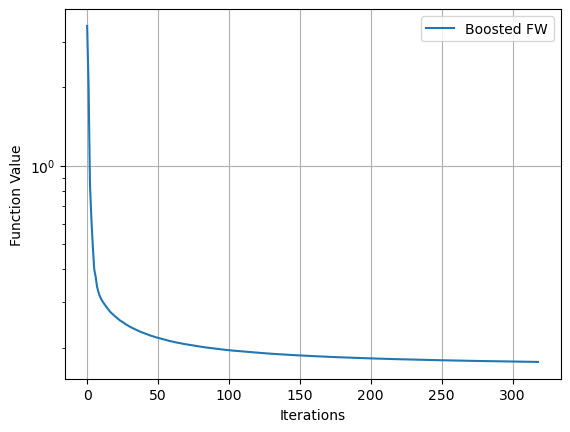

In [14]:
#Function-Value Plots

plt.semilogy(itr_b, f_values_lr_B, label = 'Boosted FW')
plt.xlabel("Iterations")
plt.ylabel("Function Value")
plt.grid(True)
plt.legend(loc = 'upper right')